# Generate strata

In [1]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from shapely import wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import xarray as xr

from sklearn import cluster
from sklearn import neighbors

/Users/etriesch/.pyenv/versions/3.9.5/envs/venv.ocean-carbon-sampling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

## Read in temp and color data

In [3]:
repo_path = Path('/Users/etriesch/dev/ocean-carbon-sampling/')
data_clean_path = repo_path / 'data/clean/'
data_raw_path = repo_path / 'data/raw/'
geo_crs = 'epsg:4326'
proj_crs = '+proj=cea'

In [18]:
# read data
t_raw = pd.read_csv(data_clean_path / 'oisst.csv')
c_raw = pd.read_csv(data_clean_path / 'chlor_a.csv')
c_ann_raw = pd.read_csv(data_clean_path / 'chlor_a_annual.csv')

In [5]:
# make geodataframes
# sst
geo = [Point(lon, lat) for lat, lon in zip(t_raw.lat, t_raw.lon)]
t_gpd = gpd.GeoDataFrame(t_raw, geometry=geo, crs=geo_crs)

In [6]:
# color
geo = [Point(lon, lat) for lat, lon in zip(c_raw.lat, c_raw.lon)]
c_gpd = gpd.GeoDataFrame(c_raw, geometry=geo, crs=geo_crs)

In [19]:
# color annual
geo = [Point(lon, lat) for lat, lon in zip(c_ann_raw.lat, c_ann_raw.lon)]
c_ann_gpd = gpd.GeoDataFrame(c_ann_raw, geometry=geo, crs=geo_crs)

In [7]:
print('SST dataset:', t_gpd.shape)
print('Color dataset:', c_gpd.shape)
rs = (t_gpd.to_crs(proj_crs)
      .sjoin_nearest(right=c_gpd.to_crs(proj_crs), how='inner', 
                     distance_col='temp', lsuffix='sst', rsuffix='col')
      .to_crs(t_gpd.crs))
print('Merged dataset:', rs.shape)

SST dataset: (15476, 8)
Color dataset: (549215, 10)
Merged dataset: (17361, 19)


# Generate strata through clustering

In [8]:
# make data to cluster on (start with pacific)
CLUSTER_VARS = ['lat_sst', 'lon_sst', 'mean_sst', 'max_col', 'months_below_mean']
pac = rs.loc[rs.pacific_sst]
X = pac[CLUSTER_VARS]
# create connectivity map
cmap = neighbors.kneighbors_graph(X[['lat_sst', 'lon_sst']].values, n_neighbors=20, mode='distance', include_self=True)
# standardize columns
X = X.transform(lambda x: (x - np.mean(x))/np.std(x))

In [9]:
# clustering
CLUSTERS = 4

# kmeans
kmeans = cluster.KMeans(n_clusters=CLUSTERS, random_state=0)
kmeans.fit(X)
pac.loc[:,'kmeans_cluster'] = kmeans.labels_

# agglomerative clustering
agclust = cluster.AgglomerativeClustering(n_clusters=CLUSTERS, connectivity=cmap)
agclust.fit(X)
pac.loc[:,'agclust_cluster'] = agclust.labels_

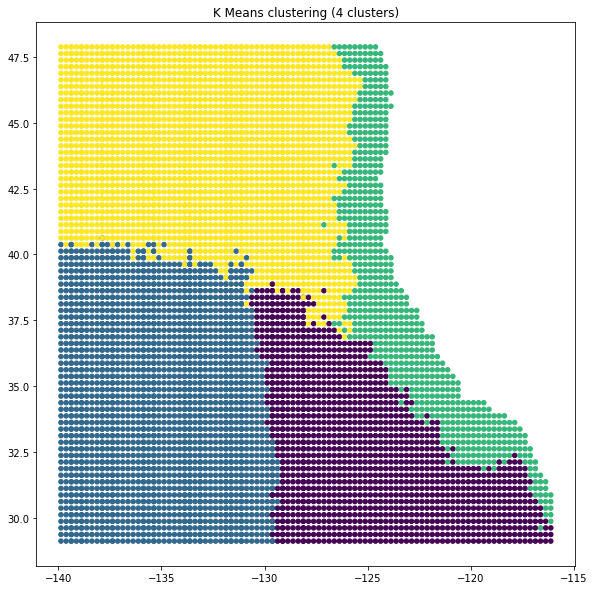

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
pac.plot(ax=ax, column='kmeans_cluster', alpha=1, markersize=20)
plt.title(f'K Means clustering ({CLUSTERS} clusters)')
plt.show()

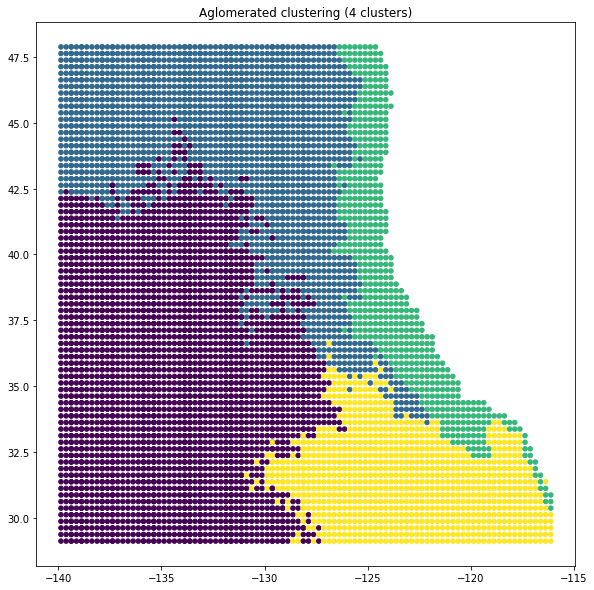

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
pac.plot(ax=ax, column='agclust_cluster', alpha=1, markersize=20)
plt.title(f'Aglomerated clustering ({CLUSTERS} clusters)')
plt.show()

## Subset to sample zones

In [12]:
# load coastlines (saved locally)
coast_fp = data_raw_path / 'tufts-contuscoastline14-shapefile.zip'
boundary_fp = data_raw_path / 'stanford-vg541kt0643-shapefile.zip'
coast = gpd.read_file(data_raw_path / coast_fp).to_crs(geo_crs)
boundary = gpd.read_file(data_raw_path / boundary_fp).to_crs(geo_crs)

In [13]:
# Monterrey desal mask
ca_cent = [-121.788649, 36.802834]
ca_lats = [33.48, 39.48]
ca_lons = [-125.48, -119.48]
# Texas desal mask
tx_cent = [-95.311296, 28.927239]
tx_lats = [25.57, 31.57]
tx_lons = [-98.21, -92.21]
# NH desal mask
nh_cent = [-70.799678, 42.563588]
nh_lats = [39.38, 45.38]
nh_lons = [-73.50, -67.50]

In [14]:
# make disks
BUFFER = 1.5
ca_disc = gpd.GeoSeries(Point(ca_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
ca_disc = gpd.GeoDataFrame(geometry=ca_disc)
tx_disc = gpd.GeoSeries(Point(tx_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
tx_disc = gpd.GeoDataFrame(geometry=tx_disc)
nh_disc = gpd.GeoSeries(Point(nh_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
nh_disc = gpd.GeoDataFrame(geometry=nh_disc)
# cut discs at coastal boundary
ca = ca_disc.overlay(boundary, how='difference')
tx = tx_disc.overlay(boundary, how='difference')
nh = nh_disc.overlay(boundary, how='difference')

[]

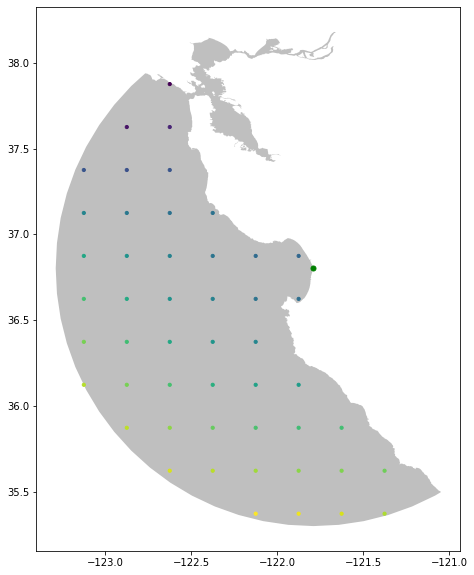

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
ca.plot(ax=ax, alpha=0.5, color='gray')
t_gpd.loc[t_gpd.pacific].overlay(ca, how='intersection').plot(ax=ax, column='mean', markersize=10)
gpd.GeoSeries(Point(ca_cent)).plot(ax=ax, color='g', markersize=25)
plt.plot()

[]

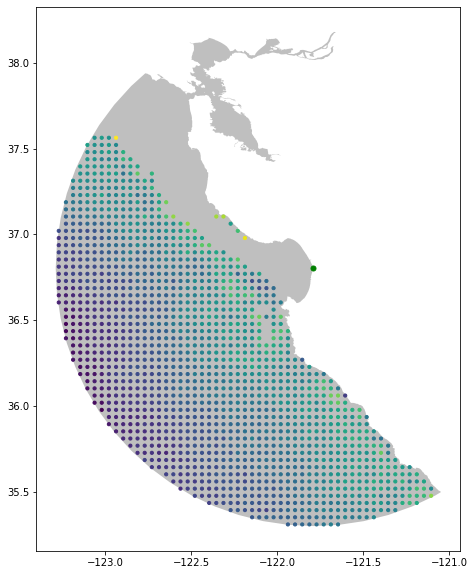

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
ca.plot(ax=ax, alpha=0.5, color='gray')
c_gpd.loc[c_gpd.pacific].overlay(ca, how='intersection').plot(ax=ax, column='mean', markersize=10)
gpd.GeoSeries(Point(ca_cent)).plot(ax=ax, color='g', markersize=25)
plt.plot()